In [1]:
import math
from copy import copy
from datetime import timedelta as delta
from glob import glob

import cmocean
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from scipy import interpolate

from parcels import (
    AdvectionRK4,
    Field,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    download_example_dataset,
)

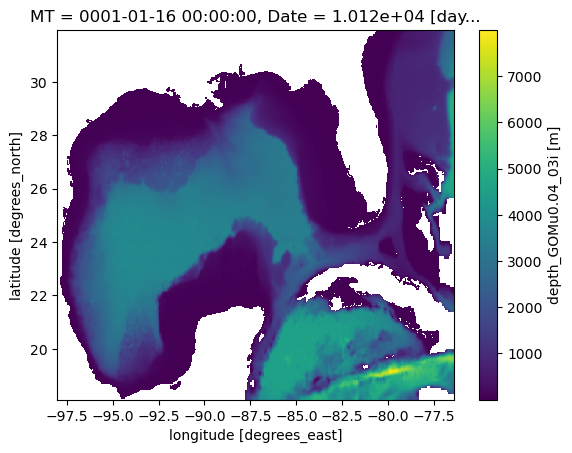

In [2]:
rawInputDir = 'data/raw_input/'

depth_HYCOM = xr.open_dataset(rawInputDir + "depth_GOMu0.04_03i.nc").isel(MT=0, Longitude=slice(0, 540))
depth_HYCOM.depth.plot()

In [3]:
# Open dataset
inputDir = 'data/input/hycom/'
flowdata_HYCOM = xr.open_dataset(inputDir+ "GOM_2019_01.nc")

flowdata_HYCOM = flowdata_HYCOM.isel(time = -1)

# Define meshgrid coordinates to plot velocity field with matplotlib pcolormesh
dlon = flowdata_HYCOM["lon"][1] - flowdata_HYCOM["lon"][0]
dlat = flowdata_HYCOM["lat"][1] - flowdata_HYCOM["lat"][0]

# Outside corner coordinates - coordinates + 0.5 dx
x_outcorners, y_outcorners = np.meshgrid(
    np.append(
        (flowdata_HYCOM["lon"] - 0.5 * dlon),
        (flowdata_HYCOM["lon"][-1] + 0.5 * dlon),
    ),
    np.append(
        (flowdata_HYCOM["lat"] - 0.5 * dlat),
        (flowdata_HYCOM["lat"][-1] + 0.5 * dlat),
    ),
)

# Inside corner coordinates - coordinates + 0.5 dx
# needed to plot cells between velocity field nodes
x_incorners, y_incorners = np.meshgrid(
    (flowdata_HYCOM["lon"] + 0.5 * dlon)[:-1],
    (flowdata_HYCOM["lat"] + 0.5 * dlat)[:-1],
)


# Center coordinates
x_centers, y_centers = np.meshgrid(
    flowdata_HYCOM["lon"], flowdata_HYCOM["lat"]
)


# --------- Velocity fields ---------

# Empty cells between coordinate nodes - essentially on inside corners
cells = np.zeros((len( flowdata_HYCOM["lat"]), len(flowdata_HYCOM["lon"])))


# # Masking the flowfield where U = NaN
umask = np.ma.masked_invalid(flowdata_HYCOM['water_u'])

# # Velocity field with NaN -> zero to be able to use in RectBivariateSpline
u_zeros = np.nan_to_num(flowdata_HYCOM['water_u'])

# Interpolate U
fu = interpolate.RectBivariateSpline(
    flowdata_HYCOM["lat"],
    flowdata_HYCOM["lon"],
    u_zeros,
    kx=1,
    ky=1,
)

# Velocity field interpolated on the inside corners
u_corners = fu(y_incorners[:, 0], x_incorners[0, :])

# Masking the interpolated flowfield where V = 0
udmask = np.ma.masked_values(u_corners, 0)

# Velocity field with NaN -> zero to be able to use in RectBivariateSpline
v_zeros = np.nan_to_num(flowdata_HYCOM['water_v'])

# Interpolate V
fv = interpolate.RectBivariateSpline(
    flowdata_HYCOM["lat"], flowdata_HYCOM["lon"], v_zeros, kx = 1, ky = 1
)

# Velocity field interpolated on the inside corners
v_corners = fv(y_incorners[:, 0], x_incorners[0, :])

# Masking the interpolated flowfield where U = 0
vdmask = np.ma.masked_values(v_corners, 0)

# --------- Plotting domain ---------
lonminx = 205
lonmaxx = 225
latminx = 277
latmaxx = 297

# Select velocity domain to plot
HYCOM_U = flowdata_HYCOM['water_u'][latminx:latmaxx, lonminx:lonmaxx].fillna(0)
HYCOM_V = flowdata_HYCOM['water_v'][latminx:latmaxx, lonminx:lonmaxx].fillna(0)

### Create seethrough colormap to show different grid interpretations
cmap = plt.get_cmap("Blues")
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = 0  # set alpha to zero
my_cmap = ListedColormap(my_cmap)

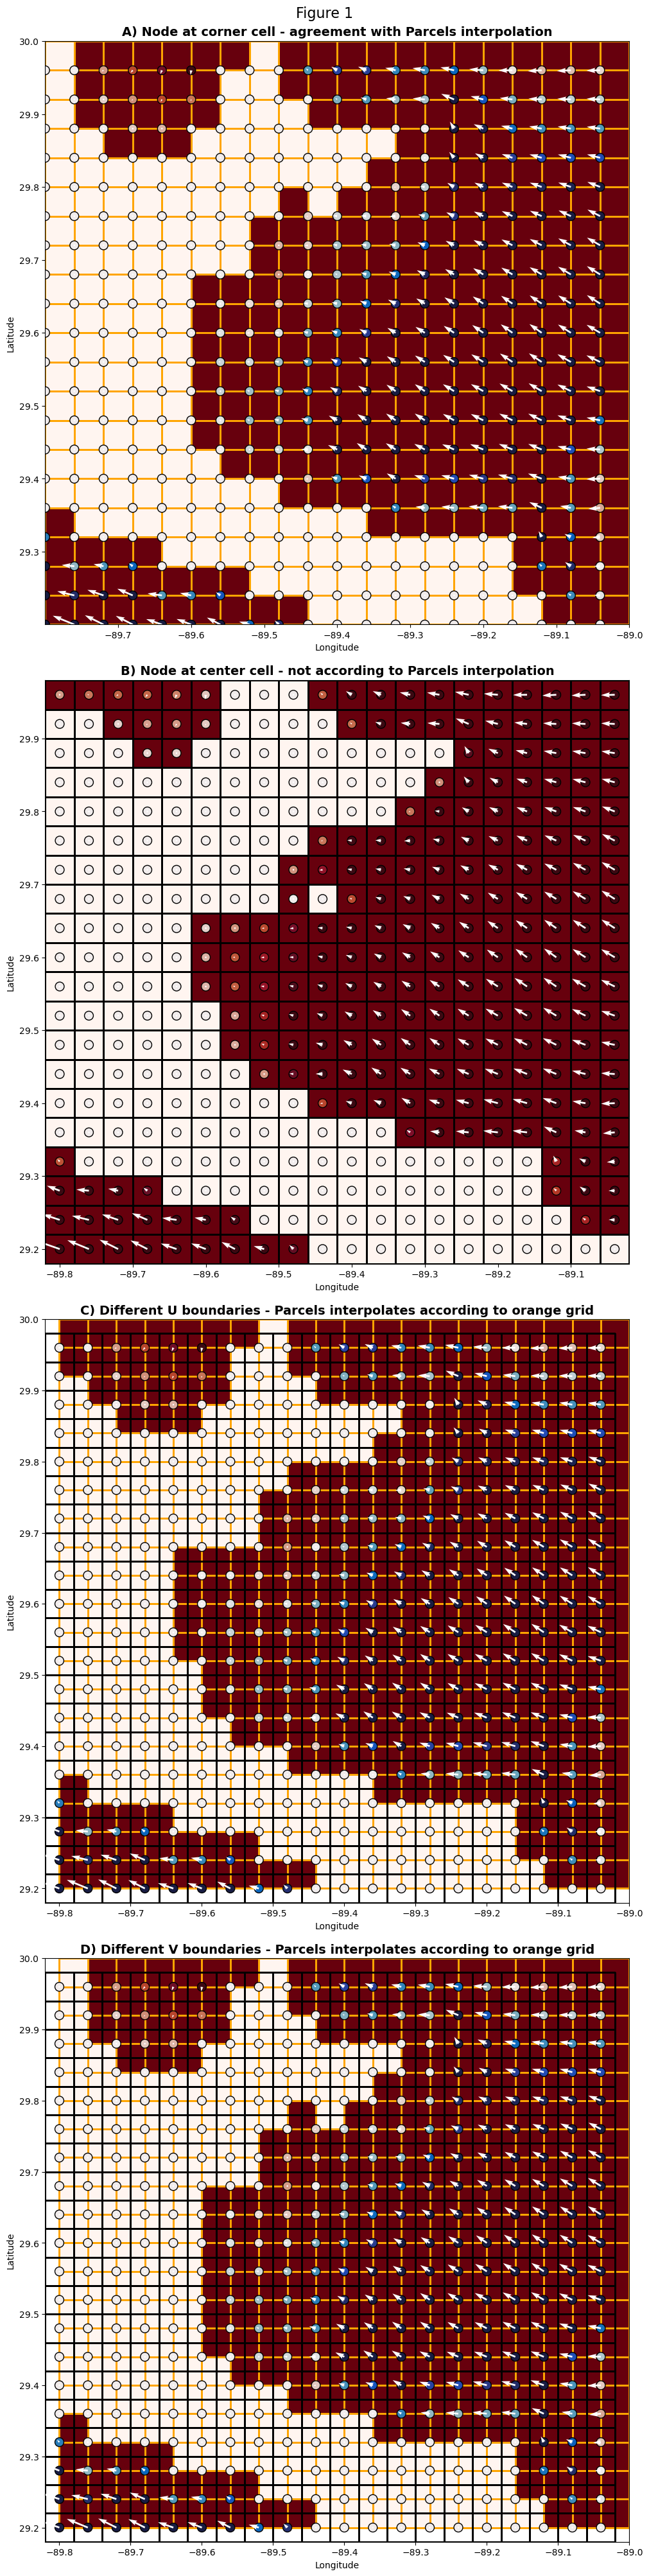

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 40), constrained_layout=True)
fig.suptitle("Figure 1", fontsize=16)

# ax1.set_xlim(-89.8, -89.4)
# ax1.set_ylim(29.0, 29.4)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title(
    "A) Node at corner cell - agreement with Parcels interpolation",
    fontsize=14,
    fontweight="bold",
)
ax1.pcolormesh(
    x_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    y_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    vdmask.mask[latminx:latmaxx, lonminx:lonmaxx],
    cmap="Reds_r",
    edgecolors="orange",
)
ax1.scatter(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    s=100,
    c=HYCOM_V,
    cmap="cmo.balance_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
ax1.quiver(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    HYCOM_U,
    HYCOM_V,
    angles="xy",
    scale_units="xy",
    scale=8,
    color="w",
    edgecolor="k",
)

# ax2.set_xlim(-89.8, -89.4)
# ax2.set_ylim(29.0, 29.4)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title(
    "B) Node at center cell - not according to Parcels interpolation",
    fontsize=14,
    fontweight="bold",
)
ax2.pcolormesh(
    x_outcorners[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    y_outcorners[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    umask.mask[latminx:latmaxx, lonminx:lonmaxx],
    cmap="Reds_r",
    edgecolors="k",
    linewidth=1,
)
ax2.scatter(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    s=100,
    c=HYCOM_U,
    cmap="cmo.balance_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
ax2.quiver(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    HYCOM_U,
    HYCOM_V,
    angles="xy",
    scale_units="xy",
    scale=8,
    color="w",
    edgecolor="k",
)

# ax3.set_xlim(-89.8, -89.4)
# ax3.set_ylim(29.0, 29.4)
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")
ax3.set_title(
    "C) Different U boundaries - Parcels interpolates according to orange grid",
    fontsize=14,
    fontweight="bold",
)
ax3.pcolormesh(
    x_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    y_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    udmask.mask[latminx:latmaxx, lonminx:lonmaxx],
    cmap="Reds_r",
    edgecolors="orange",
)
ax3.pcolormesh(
    x_outcorners[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    y_outcorners[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    cells[latminx:latmaxx, lonminx:lonmaxx],
    cmap=my_cmap,
    edgecolors="black",
)
ax3.scatter(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    s=100,
    c=HYCOM_V,
    cmap="cmo.balance_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
ax3.quiver(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    HYCOM_U,
    HYCOM_V,
    angles="xy",
    scale_units="xy",
    scale=8,
    color="w",
    edgecolor="k",
);

# ax4.set_xlim(-89.8, -89.4)
# ax4.set_ylim(29.0, 29.4)
ax4.set_xlabel("Longitude")
ax4.set_ylabel("Latitude")
ax4.set_title(
    "D) Different V boundaries - Parcels interpolates according to orange grid",
    fontsize=14,
    fontweight="bold",
)
ax4.pcolormesh(
    x_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    y_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    vdmask.mask[latminx:latmaxx, lonminx:lonmaxx],
    cmap="Reds_r",
    edgecolors="orange",
)
ax4.pcolormesh(
    x_outcorners[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    y_outcorners[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    cells[latminx:latmaxx, lonminx:lonmaxx],
    cmap=my_cmap,
    edgecolors="black",
)
ax4.scatter(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    s=100,
    c=HYCOM_V,
    cmap="cmo.balance_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
ax4.quiver(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    HYCOM_U,
    HYCOM_V,
    angles="xy",
    scale_units="xy",
    scale=8,
    color="w",
    edgecolor="k",
);

Build Cell Mask

In [5]:
landmask_ma = np.logical_or(np.ma.masked_invalid(flowdata_HYCOM['water_u']).mask, np.ma.masked_invalid(flowdata_HYCOM['water_v']))

landmask = landmask_ma.mask.astype('int')

# Interpolate UV
fl = interpolate.RectBivariateSpline(
    flowdata_HYCOM["lat"], flowdata_HYCOM["lon"], landmask, kx = 1, ky = 1
)

# Velocity field interpolated on the inside corners
l_corners = fl(y_incorners[:, 0], x_incorners[0, :])

# Masking the interpolated ocean where = 0
oceanmask = np.ma.masked_values(l_corners, 0)

# Masking the interpolated ocean where = 1
landmask = np.ma.masked_values(l_corners, 1)

# Masking the interpolated coast where 0 < 1
coastalmask = np.ma.masked_where((l_corners > 0) & (l_corners < 1), l_corners)

# Add Depth Values
depth = np.nan_to_num(depth_HYCOM.depth)

fd = interpolate.RectBivariateSpline(
    flowdata_HYCOM["lat"], flowdata_HYCOM["lon"], depth, kx = 1, ky = 1
)

# Depth field interpolated on the inside corners
d_corners = fd(y_incorners[:, 0], x_incorners[0, :])

depth_ma = np.ma.array(d_corners, mask = np.ma.masked_values((coastalmask.mask.astype(float) + oceanmask.mask.astype(float)), 1).mask)
depth = depth_ma.data
depth[~depth_ma.mask] = np.nan

# Build masks Data
gom_masks = xr.Dataset(
    {
        'depth': (['lat', 'lon' ], depth),
        'cellmask': (['lat', 'lon' ], l_corners),
        'landmask': (['lat', 'lon' ], landmask.mask.astype(float)),
        'coastalmask': (['lat', 'lon' ], coastalmask.mask.astype(float)),
        'oceanmask': (['lat', 'lon' ], oceanmask.mask.astype(float)),
    },
    coords={
        'lat': y_incorners[:, 0],
        'lon': x_incorners[0, :],
        'bin_cell_lats': flowdata_HYCOM['lat'].values,
        'bin_cell_lons': flowdata_HYCOM['lon'].values,
    },
)

In [6]:
outputDir = 'data/posterior_computation_data/'
gom_masks.to_netcdf(outputDir + 'cell_masks.nc')

Isolated Graph

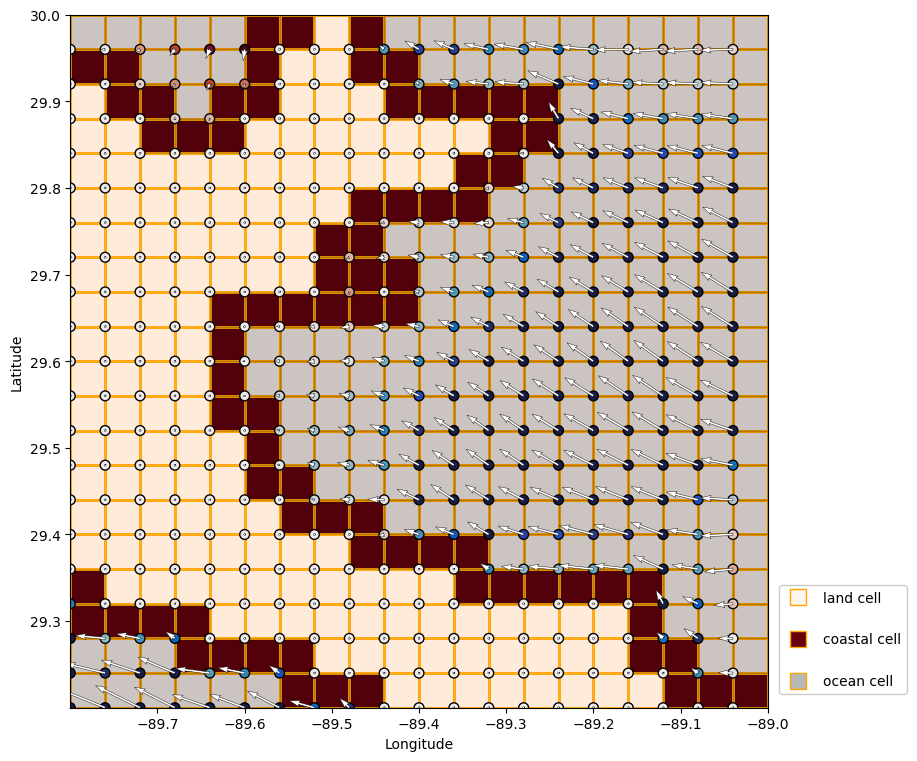

In [7]:
fig, ax1 = plt.subplots(figsize=(9, 9))
# ax1.set_xlim(-89.8, -89.4)
# ax1.set_ylim(29.0, 29.4)

color_land = copy(plt.get_cmap('Reds'))(0)
color_coast = copy(plt.get_cmap('Reds'))(256)
color_ocean = copy(plt.get_cmap('Greys'))(100)


ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
# ax1.set_title(
#     "A-Grid with Nodes at Corner Cells (Missippi Delta River)",
#     fontsize=14,
#     fontweight="bold",
# )

ax1.pcolormesh(
    x_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    y_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    coastalmask.mask[latminx:latmaxx, lonminx:lonmaxx],
    cmap="Reds",
    edgecolors="orange",
    alpha=1.0,
)

ax1.pcolormesh(
    x_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    y_centers[latminx : latmaxx + 1, lonminx : lonmaxx + 1],
    udmask.mask[latminx:latmaxx, lonminx:lonmaxx],
    cmap="copper",
    edgecolors="orange",
    alpha=0.2,
)



ax1.scatter(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    s=50,
    c=HYCOM_V,
    cmap="cmo.balance_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
ax1.quiver(
    x_centers[latminx:latmaxx, lonminx:lonmaxx],
    y_centers[latminx:latmaxx, lonminx:lonmaxx],
    HYCOM_U,
    HYCOM_V,
    angles="xy",
    scale_units="xy",
    scale=4,
    color="w",
    edgecolor="k",
    linewidth = 0.3,
)

custom_lines = [Line2D([0], [0], c = color_land, marker='s',snap=True, markersize=12, markeredgecolor='orange', lw=1),
                Line2D([0], [0], c = color_coast, marker='s', markersize=12, markeredgecolor='orange', lw=0),
                Line2D([0], [0], c = color_ocean, marker='s', markersize=12, markeredgecolor='orange', lw=0),
                ]
ax1.legend(custom_lines, ['land cell', 'coastal cell', 'ocean cell'], bbox_to_anchor=(1.12, .1), loc='lower right', borderaxespad=-4,labelspacing=2, framealpha=1.0, facecolor='w')

